In [1]:
# !pip install -U git+https://github.com/openfisca/openfisca-ceq.git@master#egg=OpenFisca-CEQ
# !pip install -U git+https://github.com/openfisca/openfisca-senegal.git@ceq#egg=OpenFisca-Senegal
# !pip install -U git+https://github.com/openfisca/openfisca-mali.git@master#egg=OpenFisca-Mali
# !pip install -U git+https://github.com/openfisca/openfisca-cote-d-ivoire.git@master#egg=OpenFisca-COTE-D-IVOIRE

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from openfisca_ceq.tools.survey_scenario import build_ceq_survey_scenario
from openfisca_ceq.tools.indirect_taxation.tax_benefit_system_indirect_taxation_completion import indirect_tax_by_country
from openfisca_ceq.tools.data import year_by_country
from openfisca_ceq.tools.data_ceq_correspondence import (
    ceq_input_by_harmonized_variable,
    ceq_intermediate_by_harmonized_variable,
    non_ceq_input_by_harmonized_variable,
    )

# Build country scenario

## Country selection

In [3]:
country = "cote_d_ivoire"

In [4]:
# Parameters
country = "senegal"


In [5]:
year = year_by_country[country]
survey_scenario = build_ceq_survey_scenario(legislation_country = country, year = year)

# Aggegates check

## Income variables

### Disagregated income variables

In [6]:
ceq_by_harmonized_variable = dict()
ceq_by_harmonized_variable.update(ceq_input_by_harmonized_variable)
ceq_by_harmonized_variable.update(ceq_intermediate_by_harmonized_variable)
ceq_by_harmonized_variable.update(non_ceq_input_by_harmonized_variable)
ceq_by_harmonized_variable['salaire_brut'] = 'salaire_brut'
ceq_by_harmonized_variable['salaire_super_brut'] = 'salaire_super_brut'
ceq_by_harmonized_variable

{'rev_i_autoconsommation': 'autoconsumption',
 'rev_i_autres': 'other_income',
 'rev_i_autres_transferts': 'gifts_sales_durables',
 'rev_i_loyers_imputes': 'imputed_rent',
 'rev_i_transferts_publics': 'direct_transfers',
 'rev_i_agricoles': 'revenu_agricole',
 'rev_i_autres_revenus_capital': 'autres_revenus_du_capital',
 'rev_i_independants_Ntaxe': 'revenu_informel_non_salarie',
 'rev_i_independants_taxe': 'revenu_non_salarie',
 'rev_i_independants': 'revenu_non_salarie_total',
 'rev_i_locatifs': 'revenu_locatif',
 'rev_i_pensions': 'pension_retraite',
 'rev_i_salaires_formels': 'salaire',
 'rev_i_salaires_informels': 'revenu_informel_salarie',
 'salaire_brut': 'salaire_brut',
 'salaire_super_brut': 'salaire_super_brut'}

In [7]:
data = [
    (harmonized_variable, openfisca_variable, survey_scenario.compute_aggregate(openfisca_variable, period = year) / 1e9) 
    for harmonized_variable, openfisca_variable in ceq_by_harmonized_variable.items()
    ]

In [8]:
revenus = pd.DataFrame(data, columns = ["harmonized", "openfisca", "aggregate"])
revenus.round(0).astype({"aggregate": int})

,harmonized,openfisca,aggregate
0,rev_i_autoconsommation,autoconsumption,157
1,rev_i_autres,other_income,148
2,rev_i_autres_transferts,gifts_sales_durables,644
3,rev_i_loyers_imputes,imputed_rent,327
4,rev_i_transferts_publics,direct_transfers,10
5,rev_i_agricoles,revenu_agricole,937
6,rev_i_autres_revenus_capital,autres_revenus_du_capital,13
7,rev_i_independants_Ntaxe,revenu_informel_non_salarie,828
8,rev_i_independants_taxe,revenu_non_salarie,264
9,rev_i_independants,revenu_non_salarie_total,1092


### Agregated income variables

#### CEQ agregated income variables

In [9]:
ceq_variables = ["market_income", "market_income_plus_pensions", "pensions", "contributions_pensions", "net_market_income", "direct_taxes", "other_contributions", "contributions_health", ]

In [10]:
ceq_aggregates = pd.DataFrame(
    index = ceq_variables,
    columns = ['aggregate'],
    data = [
        survey_scenario.compute_aggregate(ceq_variable, period = year) / 1e9 
        for ceq_variable in ceq_variables
        ]
    )
ceq_aggregates.round(0).astype({"aggregate": int})

,aggregate
market_income,4883
market_income_plus_pensions,4870
pensions,58
contributions_pensions,71
net_market_income,4718
direct_taxes,143
other_contributions,12
contributions_health,10


#### Direct check

In [11]:
income_components_summed_in_total = list(ceq_by_harmonized_variable.values()) 
income_components_summed_in_total.remove("revenu_non_salarie_total")
income_components_summed_in_total.remove("direct_transfers")
income_components_summed_in_total.remove("salaire")
income_components_summed_in_total.remove("salaire_brut")
total_income = sum(
    survey_scenario.compute_aggregate(income_component, period = survey_scenario.year) 
    for income_component in income_components_summed_in_total
    ) 
total_income = (
    total_income 
    - survey_scenario.compute_aggregate("contributions_pensions", period = survey_scenario.year)
    )/ 1e9


In [12]:
from numpy.testing import assert_almost_equal
assert_almost_equal(ceq_aggregates.loc['market_income_plus_pensions'].values, total_income, decimal = 5) 
# print('market_income_plus_pensions = {} vs {} = total_income'.format(
#         ceq_aggregates.loc['market_income_plus_pensions'].values,
#         total_income
#         )
#     )


#### Wages by public/private sector

In [13]:
"Count : {}".format(round(
    survey_scenario.compute_aggregate("secteur_public", period = year)
    ))

'Count : 84224.0'

In [14]:
(
    survey_scenario.compute_pivot_table(
        columns = ["secteur_public"], 
        values = ["salaire", "salaire_brut", "salaire_super_brut"],
        aggfunc = "sum",
        period = year,
        concat_axis = 0,
        ) / 1e9
    ).round(0).astype(int)

secteur_public,False,True
salaire,324,243
salaire_brut,446,337
salaire_super_brut,483,365


## Education variables

### Counts (in millions)

In [15]:
print((survey_scenario.compute_pivot_table(columns = ['eleve_enseignement_niveau'], index = ['eleve_enseignement_public'], aggfunc = 'count', period = survey_scenario.year) / 1e6).round(2))

eleve_enseignement_niveau   -1.0   0.0   1.0   2.0   3.0
eleve_enseignement_public                               
0.0                        10.61  0.11  0.33  0.18  0.05
1.0                         0.01  0.04  1.43  0.84  0.05


In [16]:
variables = [
    'pre_school_person',
    'pre_school',
    'primary_education_person',
    'primary_education',
    'secondary_education_person',
    'secondary_education',
    'tertiary_education_person',
    'tertiary_education',
    'education_net_transfers',
    ]
print("In kind education tranfers")
for variable in variables:
    print(
        "{variable}: {aggregate} billions FCFA".format(
            variable = variable,
            aggregate = int(round(survey_scenario.compute_aggregate(variable, period = survey_scenario.year) / 1e9))
            )
        )

In kind education tranfers
pre_school_person: 1 billions FCFA
pre_school: 1 billions FCFA
primary_education_person: 190 billions FCFA
primary_education: 190 billions FCFA
secondary_education_person: 141 billions FCFA
secondary_education: 141 billions FCFA
tertiary_education_person: 104 billions FCFA
tertiary_education: 104 billions FCFA
education_net_transfers: 436 billions FCFA


## Tax variables

### Indirect tax variables

In [17]:
indirect_tax_variables = [
    variable 
    for tax in indirect_tax_by_country[country]
    for variable in survey_scenario.tax_benefit_system.variables.keys() 
    if tax in variable 
    ]
indirect_tax_variables

['depenses_ht_tva_exonere',
 'depenses_ht_tva_taux_normal',
 'tva_taux_normal',
 'tva',
 'depenses_ht_hd_sd_droits_douane_consommation_finale',
 'depenses_ht_hd_sd_droits_douane_consommation_intermediaire',
 'depenses_ht_hd_sd_droits_douane_equipements',
 'depenses_ht_hd_sd_droits_douane_exonere',
 'droits_douane_consommation_finale',
 'droits_douane_consommation_intermediaire',
 'droits_douane_equipements',
 'droits_douane']

In [18]:
taxes_and_tariffs = pd.DataFrame(
    index = indirect_tax_variables,
    columns = ['aggregate'],
    data = [
        survey_scenario.compute_aggregate(variable, period = year) / 1e9 
        for variable in indirect_tax_variables
        ]
    )
taxes_and_tariffs.round().astype({"aggregate": int})

,aggregate
depenses_ht_tva_exonere,1526
depenses_ht_tva_taux_normal,1853
tva_taux_normal,334
tva,334
depenses_ht_hd_sd_droits_douane_consommation_finale,335
depenses_ht_hd_sd_droits_douane_consommation_intermediaire,51
depenses_ht_hd_sd_droits_douane_equipements,98
depenses_ht_hd_sd_droits_douane_exonere,64
droits_douane_consommation_finale,67
droits_douane_consommation_intermediaire,5


### Verify consumption

In [19]:
consumption = survey_scenario.compute_aggregate('consumption', period = year) / 1e9
consumption

3975.5231230319123

In [20]:
# assert consumption == 
sum(taxes_and_tariffs['aggregate'][
    taxes_and_tariffs.index.str.contains('tva_')
    ])

3712.053212390204

In [21]:
# assert consumption == 
(
    sum(
        survey_scenario.compute_aggregate(variable, period = year)
        for variable in survey_scenario.tax_benefit_system.variables
        if "depenses_ht_hd_poste" in variable 
        ) 
    + survey_scenario.compute_aggregate("droits_douane", period = year)
    + survey_scenario.compute_aggregate("tva", period = year)
    ) / 1e9

3712.053151153752

# Inflate incomes   

## Income variables

In [22]:
income_variables = [
    'autoconsumption',
    'other_income',
    'gifts_sales_durables',
    'imputed_rent',
    'revenu_agricole',
    'autres_revenus_du_capital',
    'revenu_informel_non_salarie',
    'revenu_non_salarie',
    'revenu_locatif',
    'pension_retraite',
    'salaire_super_brut',
    ]

In [23]:
sum(
    survey_scenario.compute_aggregate(income_variable, period = year)
    for income_variable in income_variables
    ) / 1e9

4278.090574075829

In [24]:
# inflated_survey_scenario = build_ceq_survey_scenario(
#     legislation_country = country, 
#     year = year,
#     inflate = True,
#     income_variables = income_variables
#     )

In [25]:
# sum(
#     inflated_survey_scenario.compute_aggregate(income_variable, period = year)
#     for income_variable in income_variables
#     ) / 1e9

# Indicators

In [26]:
from openfisca_survey_manager.statshelpers import gini, bottom_share, top_share, lorenz
variables = [
    "market_income", 
    "market_income_plus_pensions",
    "gross_income",
    "disposable_income",
    "consumable_income", 
    "final_income",
    ]
variable = "market_income"
weights = survey_scenario.calculate_variable("household_weight", period = year)
BOTTOM_SHARE = .4
TOP_SHARE = .1
pd.DataFrame.from_dict(
    dict([
        (
            variable, 
            {
                "Gini": gini(survey_scenario.calculate_variable(variable, period = year), weights),
                "Bottom 40 %": bottom_share(survey_scenario.calculate_variable(variable, period = year), BOTTOM_SHARE, weights = weights),
                "Top 10 %": top_share(survey_scenario.calculate_variable(variable, period = year), TOP_SHARE, weights = weights),
                }
            ) 
        for variable in variables
        ])
    ).round(2)

,market_income,market_income_plus_pensions,gross_income,disposable_income,consumable_income,final_income
Gini,0.53,0.53,0.53,0.52,0.54,0.52
Bottom 40 %,0.10,0.10,0.10,0.10,0.09,0.10
Top 10 %,0.38,0.38,0.38,0.37,0.39,0.37


In [27]:
survey_scenario.compute_aggregate("impots_indirects", period = year) / 1e9

410.55225247829554

In [28]:
survey_scenario.compute_aggregate("direct_taxes", period = year) / 1e9

142.77685950326898

In [29]:
survey_scenario.compute_aggregate("personal_income_tax", period = year) / 1e9

142.77685950326898

In [30]:
from openfisca_ceq import list_variables_from_directory

In [31]:
ceq_variables = sorted(list_variables_from_directory(survey_scenario.tax_benefit_system))
[
    ceq_variable
    for ceq_variable in ceq_variables
    if survey_scenario.compute_aggregate(ceq_variable, period = year) == 0
    ]

['agricultural_inputs_subsidies',
 'alimony',
 'corporate_income_tax',
 'electricity_subsidies',
 'employee_contributions_health',
 'employee_other_contributions',
 'excise_taxes',
 'food_subsidies',
 'fuel_subsidies',
 'indirect_subsidies',
 'other_taxes',
 'payroll_tax',
 'property_tax',
 'sales_tax',
 'self_employed_contributions_health',
 'self_employed_contributions_pensions',
 'self_employed_other_contributions']

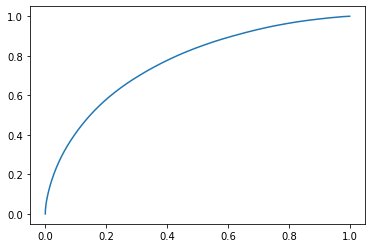

In [32]:
variable = "market_income"
y, x = lorenz(survey_scenario.calculate_variable(variable, period = year), weights = weights)
plt.plot(x, y)

In [33]:
survey_scenario.compute_aggregate('direct_transfers', period = year) / 1e9

9.702591178131149

In [34]:
ceq_variables

['agricultural_inputs_subsidies',
 'alimony',
 'all_income_excluding_transfers',
 'autoconsumption',
 'consumable_income',
 'contributions_health',
 'contributions_pensions',
 'corporate_income_tax',
 'customs_duties',
 'direct_taxes',
 'disposable_income',
 'electricity_subsidies',
 'employee_contributions_health',
 'employee_contributions_pensions',
 'employee_other_contributions',
 'employer_contributions_health',
 'employer_contributions_pensions',
 'employer_other_contributions',
 'excise_taxes',
 'final_income',
 'food_subsidies',
 'fuel_subsidies',
 'gifts_sales_durables',
 'gross_income',
 'imputed_rent',
 'indirect_subsidies',
 'indirect_taxes',
 'market_income',
 'market_income_plus_pensions',
 'net_market_income',
 'nontaxable_income',
 'other_contributions',
 'other_income',
 'other_taxes',
 'payroll_tax',
 'pensions',
 'personal_income_tax',
 'property_tax',
 'sales_tax',
 'self_employed_contributions_health',
 'self_employed_contributions_pensions',
 'self_employed_other_